In [1]:
!pip install rdkit-pypi
!pip install openpyxl
!pip install rdkit-pypi avalon_framework

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for avalon_framework: filename=avalon_framework-1.8.2-py3-none-any.whl size=3868 sha256=b6691b40856766661ca2108426f16f0dfd0a9514803e766dd65d84c4a9f7b98e
  Stored in directory: /root/.cache/pip/wheels/19/a3/86/e8991278ac56c74bdc9382f08c2790b5c3bbcd8ea5c08f9a90
Successfully built avalon_framework


In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

# Morgan training

<Figure size 800x800 with 0 Axes>

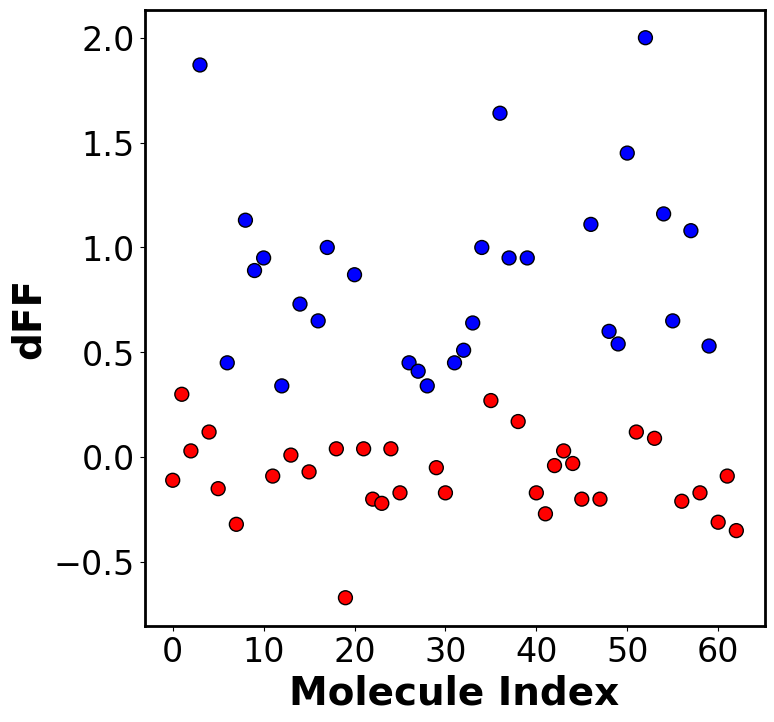

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem

# Set seed for reproducibility
seed_value = 45
np.random.seed(seed_value)
# Load the Excel file
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Replace with actual file path

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']
homo_column = df['HOMO (eV)']
lumo_column = df['LUMO (eV)']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()
homo_values = df['HOMO (eV)'].to_numpy().astype(float)
lumo_values = df['LUMO (eV)'].to_numpy().astype(float)

# Create 'Class' column based on dFF values
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Scatter plot: dFF vs Molecules, colored by Class
plt.figure(figsize=(8, 8))
molecule_indices = range(len(df))
colors = df["Class"].map({0: 'red', 1: 'blue'})  # Color based on Class (0 = red, 1 = blue)

# === Generate Morgan fingerprints ===
mols = [Chem.MolFromSmiles(sm) for sm in smiles_list]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in mols]
# Create 'Class' column based on dFF values
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Scatter plot: dFF vs Molecules, colored by Class
plt.figure(figsize=(8, 8))
molecule_indices = range(len(df))
colors = df["Class"].map({0: 'red', 1: 'blue'})  # Color based on Class (0 = red, 1 = blue)

plt.scatter(molecule_indices, df['dFF'], c=colors, s=100, edgecolor='black')

# Set plot parameters
plt.xlabel('Molecule Index', fontsize=28, weight='bold')
plt.ylabel('dFF', fontsize=28, weight='bold')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Save the scatter plot as a high-resolution image
plt.savefig('dFF_vs_molecules_scatter.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



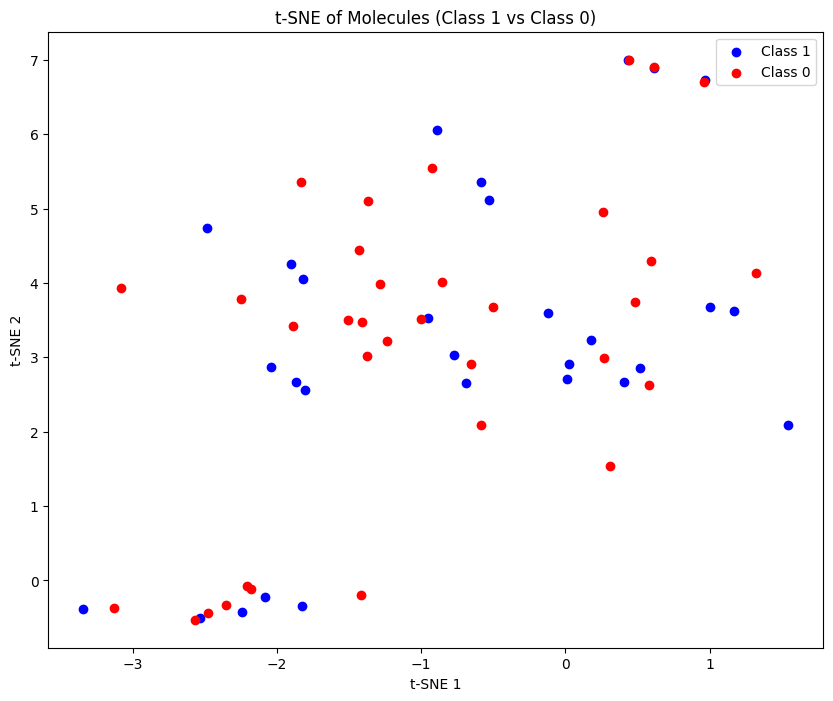

<Figure size 640x480 with 0 Axes>

In [ ]:
# Separate molecules into class 1 and class 0
class_1 = df[df['Class'] == 1]
class_0 = df[df['Class'] == 0]

# Combine the molecules into one dataset for t-SNE
all_molecules = pd.concat([class_1, class_0])

# Convert RDKit fingerprints to a list of lists
fingerprints_list = [list(fp.ToBitString()) for fp in fingerprints]

# Extract features (fingerprints, HOMO, LUMO) for t-SNE
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

# Run t-SNE on the combined dataset
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add the t-SNE results to the DataFrame
all_molecules['tsne-2d-one'] = tsne_results[:, 0]
all_molecules['tsne-2d-two'] = tsne_results[:, 1]

# Plot t-SNE results, colored by class
plt.figure(figsize=(10, 8))

# Scatter plot for Class 1 (positive dFF)
plt.scatter(all_molecules[all_molecules['Class'] == 1]['tsne-2d-one'],
            all_molecules[all_molecules['Class'] == 1]['tsne-2d-two'],
            color='blue', label='Class 1')

# Scatter plot for Class 0 (negative or neutral dFF)
plt.scatter(all_molecules[all_molecules['Class'] == 0]['tsne-2d-one'],
            all_molecules[all_molecules['Class'] == 0]['tsne-2d-two'],
            color='red', label='Class 0')

plt.legend()
plt.title('t-SNE of Molecules (Class 1 vs Class 0)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Save t-SNE results to a CSV file
all_molecules.to_csv('tsne_results.csv', index=False)
# Save the plot as a PNG image
plt.savefig('tsne_plot.png')


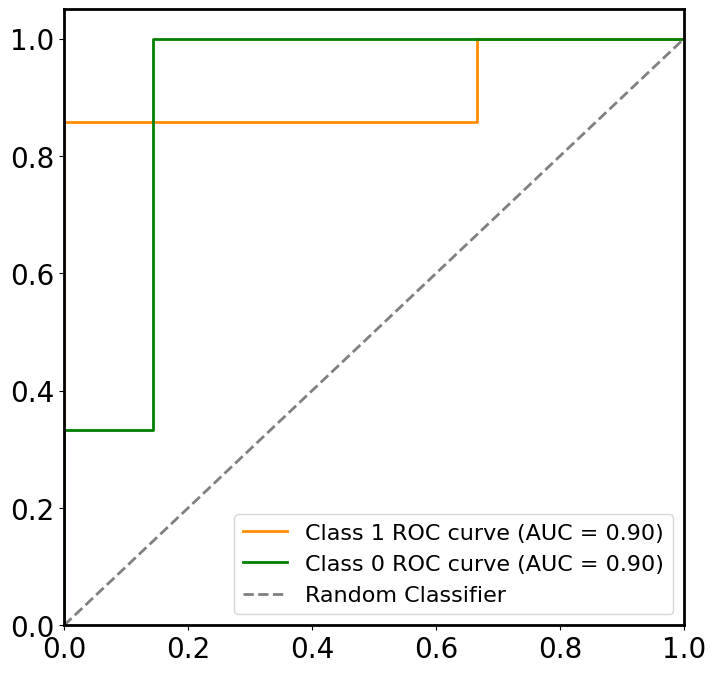

AUC for Class 1 (Positive): 0.9048
AUC for Class 0 (Negative): 0.9048
Best model index: 33
Best F1 score: 0.9231


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

from rdkit.Chem import MACCSkeys

# Load the Excel file containing SMILES, CLASS, HOMO, and LUMO data
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Replace 'your_excel_file.xlsx' with the actual file name

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Rename the DataFrame columns
df.columns = column_names
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']
homo_column = df['HOMO (eV)']
lumo_column = df['LUMO (eV)']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Convert HOMO and LUMO columns to numeric arrays
homo_values = homo_column.to_numpy().astype(float)
lumo_values = lumo_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in mols]
# Combine fingerprints, HOMO, and LUMO into features (Assumed 'homo_values' and 'lumo_values' are defined)
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

# Initialize lists to store evaluation metrics and confusion matrices
confusion_matrix_list = []
metrics_list = []

# Initialize variables to track the best model
best_model_index = -1
best_f1_score = -1
best_accuracy = -1
best_model = None
best_x_test = None
best_y_test = None
best_y_prob = None

num_models = 200  # Number of models to run

# Run the model 200 times with different random states
for i in range(num_models):
    # Shuffle the data using a random number generator
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation]  # Assumed 'df["Class"]' contains the labels

    # Split the shuffled features and labels into training and testing datasets
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Initialize and train the SVC model
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)  # Probability for both classes (class 0 and class 1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # ROC curve and AUC for class 1 (positive class)
    fpr_class1, tpr_class1, thresholds_class1 = roc_curve(y_test, y_prob[:, 1])
    roc_auc_class1 = auc(fpr_class1, tpr_class1)

    # Ignore models with perfect scores (accuracy, F1 score, or AUC == 1)
    if accuracy == 1 or f1 == 1 or roc_auc_class1 == 1:
        continue  # Skip this model

    # Append metrics to the list
    metrics_list.append({"Model": i + 1, "Accuracy": accuracy, "F1 Score": f1, "Recall": recall, "AUC": roc_auc_class1})
    confusion_matrix_list.append(cm)

    # Check if this model has the best F1 score so far
    if f1 > best_f1_score:
        best_f1_score = f1
        best_accuracy = accuracy
        best_model_index = i
        best_model = model
        best_x_test = x_test
        best_y_test = y_test
        best_y_prob = y_prob

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame to a CSV file
metrics_df.to_csv("individual_metrics-t3-seed45-Morgan-energy.csv", index=False)

# For the best performing model, calculate the ROC curve and AUC for both classes (class 0 and class 1)
y_prob = best_model.predict_proba(best_x_test)  # Probabilities for both classes (class 0 and class 1)

# ROC curve and AUC for class 1 (positive class)
fpr_class1, tpr_class1, thresholds_class1 = roc_curve(best_y_test, y_prob[:, 1])
roc_auc_class1 = auc(fpr_class1, tpr_class1)

# ROC curve and AUC for class 0 (negative class)
fpr_class0, tpr_class0, thresholds_class0 = roc_curve(best_y_test, y_prob[:, 0], pos_label=0)
roc_auc_class0 = auc(fpr_class0, tpr_class0)

# Plot the ROC curves for both classes
plt.figure(figsize=(8, 8))  # Set a square figure size, 6x6 inches

# Class 1 (positive class) in orange
plt.plot(fpr_class1, tpr_class1, color='darkorange', lw=2, label=f'Class 1 ROC curve (AUC = {roc_auc_class1:.2f})')

# Class 0 (negative class) in green
plt.plot(fpr_class0, tpr_class0, color='green', lw=2, label=f'Class 0 ROC curve (AUC = {roc_auc_class0:.2f})')

# Reference diagonal line in grey
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Random Classifier')

# Set plot limits to start at 0
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Customize tick labels (28 size)
plt.tick_params(axis='both', which='major', labelsize=20)

# Customize axis line thickness (3)
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Labels and title
#plt.xlabel('False Positive Rate', fontsize=28)
#plt.ylabel('True Positive Rate', fontsize=28)
#plt.title('Receiver Operating Characteristic for Both Classes', fontsize=28)

# Add legend
plt.legend(loc="lower right", fontsize=16)

# Save the figure as a high-resolution image (300 dpi)
plt.savefig("roc_curve_high_res_square_custom_one_zero.png", dpi=300)

# Show the plot
plt.show()

# Print the AUC values for both classes
print(f"AUC for Class 1 (Positive): {roc_auc_class1:.4f}")
print(f"AUC for Class 0 (Negative): {roc_auc_class0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1_score:.4f}")










# MACCS training

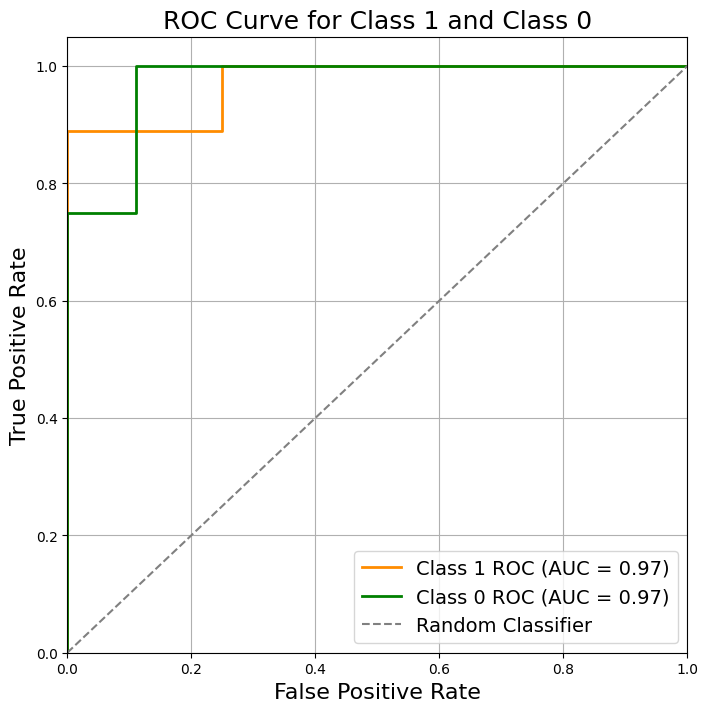

AUC for Class 1 (Positive): 0.9722
AUC for Class 0 (Negative): 0.9722
Best model index: 112
Best F1 score: 0.9474


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix

# === Load and preprocess data ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]
df["Class"] = (df["dFF"] > 0.3).astype(int)

smiles_list = df['Smiles'].to_list()
homo_values = df['HOMO (eV)'].to_numpy().astype(float)
lumo_values = df['LUMO (eV)'].to_numpy().astype(float)

mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
fingerprints = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
fingerprints_list = [list(fp.ToBitString()) for fp in fingerprints]

features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

# === Model training ===
seed_value = 45
np.random.seed(seed_value)

num_models = 200
metrics_list = []
confusion_matrix_list = []

# Track best high-but-not-perfect model
best_model = None
best_f1 = -1
best_model_index = -1
best_x_test = None
best_y_test = None
best_y_prob = None

for i in range(num_models):
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(
        shuffled_features, shuffled_labels, test_size=0.20, random_state=i
    )

    model = SVC(probability=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    metrics_list.append({"Model": i + 1, "Accuracy": acc, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Track best "realistic" model
    if f1 > 0.85 and acc > 0.85 and f1 < 1.0 and acc < 1.0:
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_model_index = i
            best_x_test = x_test
            best_y_test = y_test
            best_y_prob = y_prob

# === Save all metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("individual_metrics-t3-seed45-MACCS-energy.csv", index=False)

# === Generate ROC for both classes ===
fpr1, tpr1, _ = roc_curve(best_y_test, best_y_prob[:, 1])  # Class 1
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, best_y_prob[:, 0], pos_label=0)  # Class 0
auc0 = auc(fpr0, tpr0)

# === Pad ROC arrays to equal length for Origin
max_len = max(len(fpr1), len(fpr0))
fpr1 = np.pad(fpr1, (0, max_len - len(fpr1)), constant_values=np.nan)
tpr1 = np.pad(tpr1, (0, max_len - len(tpr1)), constant_values=np.nan)
fpr0 = np.pad(fpr0, (0, max_len - len(fpr0)), constant_values=np.nan)
tpr0 = np.pad(tpr0, (0, max_len - len(tpr0)), constant_values=np.nan)

# === Save ROC data to CSV for Origin
roc_df = pd.DataFrame({
    "FPR_Class1": fpr1,
    "TPR_Class1": tpr1,
    "FPR_Class0": fpr0,
    "TPR_Class0": tpr0
})
roc_df.to_csv("roc_curve_data_for_origin.csv", index=False)

# === Save AUC info
with open("roc_auc_info.txt", "w") as f:
    f.write(f"AUC Class 1 = {auc1:.4f}\n")
    f.write(f"AUC Class 0 = {auc0:.4f}\n")
    f.write(f"Best Model Index = {best_model_index + 1}\n")
    f.write(f"Best F1 Score = {best_f1:.4f}\n")

# === Plot ROC curves (optional)
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, label=f"Class 1 ROC (AUC = {auc1:.2f})", lw=2, color='darkorange')
plt.plot(fpr0, tpr0, label=f"Class 0 ROC (AUC = {auc0:.2f})", lw=2, color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label="Random Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve for Class 1 and Class 0", fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.savefig("roc_curve_class1_class0.png", dpi=300)
plt.show()

# === Print summary
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1:.4f}")



# Daylight Training

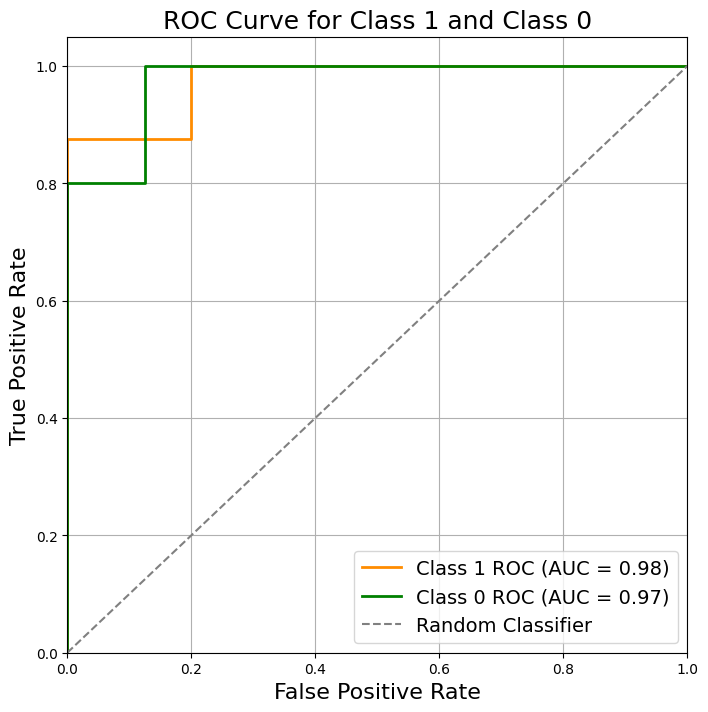

AUC for Class 1 (Positive): 0.9750
AUC for Class 0 (Negative): 0.9750
Best model index: 10
Best F1 score: 0.9333


In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# === Load and preprocess data ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]
df["Class"] = (df["dFF"] > 0.3).astype(int)

smiles_list = df['Smiles'].to_list()
homo_values = df['HOMO (eV)'].to_numpy().astype(float)
lumo_values = df['LUMO (eV)'].to_numpy().astype(float)

# === Generate Daylight fingerprints ===
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
Daylight_fingerprints = [Chem.RDKFingerprint(mol) for mol in mols]
fingerprints_list = [list(map(int, fp.ToBitString())) for fp in Daylight_fingerprints]

# === Combine fingerprints with energy features ===
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

# === Model training ===
seed_value = 45
np.random.seed(seed_value)

num_models = 200
metrics_list = []
confusion_matrix_list = []

# Track best high-but-not-perfect model
best_model = None
best_f1 = -1
best_model_index = -1
best_x_test = None
best_y_test = None
best_y_prob = None

for i in range(num_models):
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(
        shuffled_features, shuffled_labels, test_size=0.20, random_state=i
    )

    model = SVC(probability=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    metrics_list.append({"Model": i + 1, "Accuracy": acc, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Track best "realistic" model
    if f1 > 0.85 and acc > 0.85 and f1 < 1.0 and acc < 1.0:
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_model_index = i
            best_x_test = x_test
            best_y_test = y_test
            best_y_prob = y_prob

# === Save all metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("individual_metrics-t3-seed45-Daylight-energy.csv", index=False)

# === Generate ROC for both classes ===
fpr1, tpr1, _ = roc_curve(best_y_test, best_y_prob[:, 1])  # Class 1
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, best_y_prob[:, 0], pos_label=0)  # Class 0
auc0 = auc(fpr0, tpr0)

# === Pad ROC arrays to equal length for Origin
max_len = max(len(fpr1), len(fpr0))
fpr1 = np.pad(fpr1, (0, max_len - len(fpr1)), constant_values=np.nan)
tpr1 = np.pad(tpr1, (0, max_len - len(tpr1)), constant_values=np.nan)
fpr0 = np.pad(fpr0, (0, max_len - len(fpr0)), constant_values=np.nan)
tpr0 = np.pad(tpr0, (0, max_len - len(tpr0)), constant_values=np.nan)

# === Save ROC data to CSV for Origin
roc_df = pd.DataFrame({
    "FPR_Class1": fpr1,
    "TPR_Class1": tpr1,
    "FPR_Class0": fpr0,
    "TPR_Class0": tpr0
})
roc_df.to_csv("roc_curve_data_for_origin.csv", index=False)

# === Save AUC info
with open("roc_auc_info.txt", "w") as f:
    f.write(f"AUC Class 1 = {auc1:.4f}\n")
    f.write(f"AUC Class 0 = {auc0:.4f}\n")
    f.write(f"Best Model Index = {best_model_index + 1}\n")
    f.write(f"Best F1 Score = {best_f1:.4f}\n")

# === Plot ROC curves (optional)
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, label=f"Class 1 ROC (AUC = {auc1:.2f})", lw=2, color='darkorange')
plt.plot(fpr0, tpr0, label=f"Class 0 ROC (AUC = {auc0:.2f})", lw=2, color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label="Random Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve for Class 1 and Class 0", fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.savefig("roc_curve_class1_class0.png", dpi=300)
plt.show()

# === Print summary
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1:.4f}")


# AtomPairs training

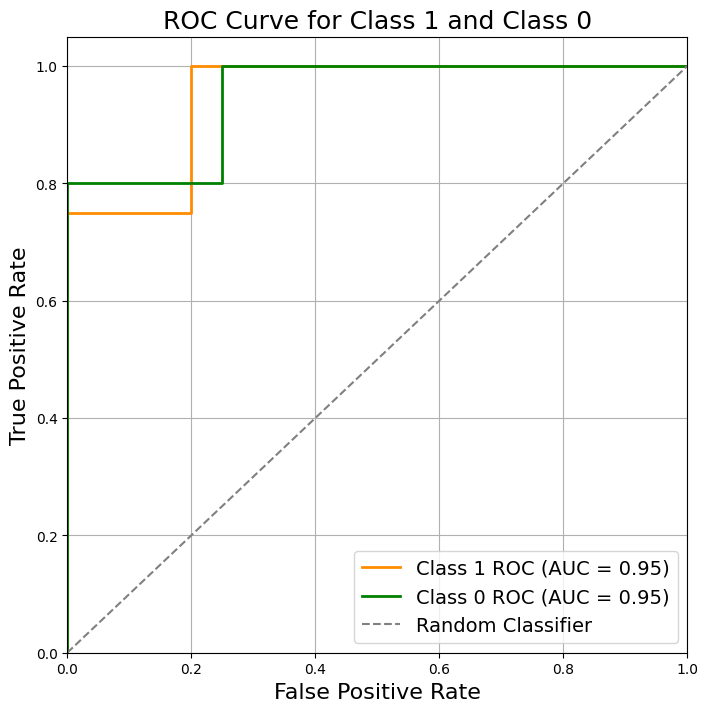

AUC for Class 1 (Positive): 0.9500
AUC for Class 0 (Negative): 0.9500
Best model index: 139
Best F1 score: 0.9412


In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# === Load and preprocess data ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]
df["Class"] = (df["dFF"] > 0.3).astype(int)

smiles_list = df['Smiles'].to_list()
homo_values = df['HOMO (eV)'].to_numpy().astype(float)
lumo_values = df['LUMO (eV)'].to_numpy().astype(float)

# === Generate AtomPairs fingerprints ===
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
atompair_fps = [rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol) for mol in mols]
fingerprints_list = [list(map(int, fp.ToBitString())) for fp in atompair_fps]

# === Combine fingerprints with energy features ===
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

# === Model training ===
seed_value = 45
np.random.seed(seed_value)

num_models = 200
metrics_list = []
confusion_matrix_list = []

# Track best high-but-not-perfect model
best_model = None
best_f1 = -1
best_model_index = -1
best_x_test = None
best_y_test = None
best_y_prob = None

for i in range(num_models):
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(
        shuffled_features, shuffled_labels, test_size=0.20, random_state=i
    )

    model = SVC(probability=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    metrics_list.append({"Model": i + 1, "Accuracy": acc, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Track best "realistic" model
    if f1 > 0.85 and acc > 0.85 and f1 < 1.0 and acc < 1.0:
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_model_index = i
            best_x_test = x_test
            best_y_test = y_test
            best_y_prob = y_prob

# === Save all metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("individual_metrics-t3-seed45-AtomPairs-energy.csv", index=False)

# === Generate ROC for both classes ===
fpr1, tpr1, _ = roc_curve(best_y_test, best_y_prob[:, 1])  # Class 1
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, best_y_prob[:, 0], pos_label=0)  # Class 0
auc0 = auc(fpr0, tpr0)

# === Pad ROC arrays to equal length for Origin
max_len = max(len(fpr1), len(fpr0))
fpr1 = np.pad(fpr1, (0, max_len - len(fpr1)), constant_values=np.nan)
tpr1 = np.pad(tpr1, (0, max_len - len(tpr1)), constant_values=np.nan)
fpr0 = np.pad(fpr0, (0, max_len - len(fpr0)), constant_values=np.nan)
tpr0 = np.pad(tpr0, (0, max_len - len(tpr0)), constant_values=np.nan)

# === Save ROC data to CSV for Origin
roc_df = pd.DataFrame({
    "FPR_Class1": fpr1,
    "TPR_Class1": tpr1,
    "FPR_Class0": fpr0,
    "TPR_Class0": tpr0
})
roc_df.to_csv("roc_curve_data_for_origin.csv", index=False)

# === Save AUC info
with open("roc_auc_info.txt", "w") as f:
    f.write(f"AUC Class 1 = {auc1:.4f}\n")
    f.write(f"AUC Class 0 = {auc0:.4f}\n")
    f.write(f"Best Model Index = {best_model_index + 1}\n")
    f.write(f"Best F1 Score = {best_f1:.4f}\n")

# === Plot ROC curves (optional)
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, label=f"Class 1 ROC (AUC = {auc1:.2f})", lw=2, color='darkorange')
plt.plot(fpr0, tpr0, label=f"Class 0 ROC (AUC = {auc0:.2f})", lw=2, color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label="Random Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve for Class 1 and Class 0", fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.savefig("roc_curve_class1_class0.png", dpi=300)
plt.show()

# === Print summary
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1:.4f}")


# Avalon training

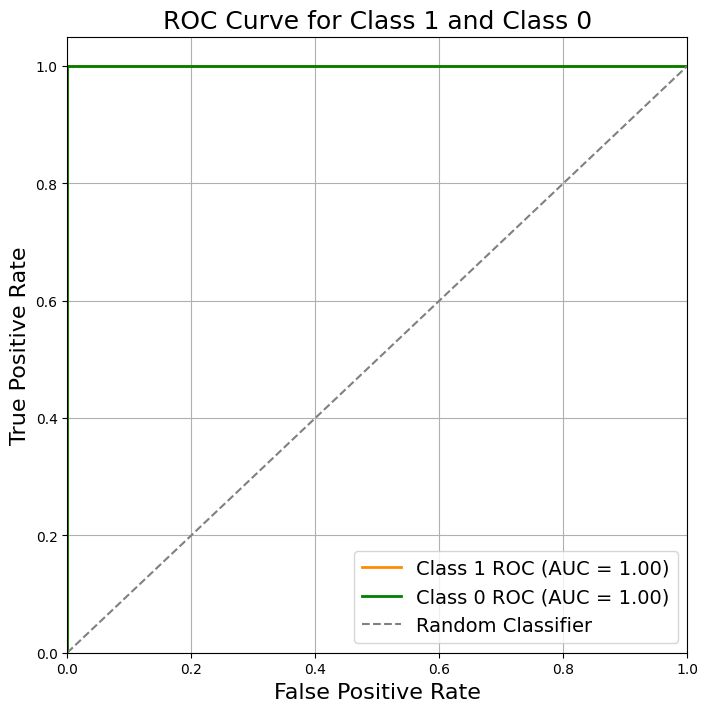

AUC for Class 1 (Positive): 1.0000
AUC for Class 0 (Negative): 1.0000
Best model index: 42
Best F1 score: 0.9412


In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# === Load and preprocess data ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]
df["Class"] = (df["dFF"] > 0.3).astype(int)

smiles_list = df['Smiles'].to_list()
homo_values = df['HOMO (eV)'].to_numpy().astype(float)
lumo_values = df['LUMO (eV)'].to_numpy().astype(float)

# === Generate Avalon fingerprints ===
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
avalon_fps = [GetAvalonFP(mol, nBits=2048) for mol in mols]
fingerprints_list = [list(map(int, fp.ToBitString())) for fp in avalon_fps]

# === Combine fingerprints with energy features ===
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

# === Model training ===
seed_value = 45
np.random.seed(seed_value)

num_models = 200
metrics_list = []
confusion_matrix_list = []

# Track best high-but-not-perfect model
best_model = None
best_f1 = -1
best_model_index = -1
best_x_test = None
best_y_test = None
best_y_prob = None

for i in range(num_models):
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(
        shuffled_features, shuffled_labels, test_size=0.20, random_state=i
    )

    model = SVC(probability=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    metrics_list.append({"Model": i + 1, "Accuracy": acc, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Track best "realistic" model
    if f1 > 0.85 and acc > 0.85 and f1 < 1.0 and acc < 1.0:
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_model_index = i
            best_x_test = x_test
            best_y_test = y_test
            best_y_prob = y_prob

# === Save all metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("individual_metrics-t3-seed45-Avalon-energy.csv", index=False)

# === Generate ROC for both classes ===
fpr1, tpr1, _ = roc_curve(best_y_test, best_y_prob[:, 1])  # Class 1
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, best_y_prob[:, 0], pos_label=0)  # Class 0
auc0 = auc(fpr0, tpr0)

# === Pad ROC arrays to equal length for Origin
max_len = max(len(fpr1), len(fpr0))
fpr1 = np.pad(fpr1, (0, max_len - len(fpr1)), constant_values=np.nan)
tpr1 = np.pad(tpr1, (0, max_len - len(tpr1)), constant_values=np.nan)
fpr0 = np.pad(fpr0, (0, max_len - len(fpr0)), constant_values=np.nan)
tpr0 = np.pad(tpr0, (0, max_len - len(tpr0)), constant_values=np.nan)

# === Save ROC data to CSV for Origin
roc_df = pd.DataFrame({
    "FPR_Class1": fpr1,
    "TPR_Class1": tpr1,
    "FPR_Class0": fpr0,
    "TPR_Class0": tpr0
})
roc_df.to_csv("roc_curve_data_for_origin.csv", index=False)

# === Save AUC info
with open("roc_auc_info.txt", "w") as f:
    f.write(f"AUC Class 1 = {auc1:.4f}\n")
    f.write(f"AUC Class 0 = {auc0:.4f}\n")
    f.write(f"Best Model Index = {best_model_index + 1}\n")
    f.write(f"Best F1 Score = {best_f1:.4f}\n")

# === Plot ROC curves (optional)
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, label=f"Class 1 ROC (AUC = {auc1:.2f})", lw=2, color='darkorange')
plt.plot(fpr0, tpr0, label=f"Class 0 ROC (AUC = {auc0:.2f})", lw=2, color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label="Random Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve for Class 1 and Class 0", fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.savefig("roc_curve_class1_class0.png", dpi=300)
plt.show()

# === Print summary
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1:.4f}")


# Torsion training

In [ ]:
from rdkit.Chem import rdMolDescriptors

# Load the Excel file containing SMILES, CLASS, HOMO, and LUMO data
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Replace 'your_excel_file.xlsx' with the actual file name

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']
homo_column = df['HOMO (eV)']
lumo_column = df['LUMO (eV)']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Convert HOMO and LUMO columns to numeric arrays
homo_values = homo_column.to_numpy().astype(float)
lumo_values = lumo_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
torsion_fingerprints = [rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol) for mol in mols]

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

# Convert RDKit fingerprints to a list of lists
fingerprints_list = [list(fp.ToBitString()) for fp in torsion_fingerprints]

# Combine fingerprints, HOMO, and LUMO into features
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))


# Initialize lists to store evaluation metrics and confusion matrices
confusion_matrix_list = []
metrics_list = []

# Initialize variables to track the 5 best models
top_models_indices = []
top_models_f1_scores = []
top_models_accuracies = []

num_models = 200

# Initialize variables to track the best model
#best_model_index = -1
#best_f1_score = -1
#best_accuracy = -1

# Run the model 200 times with different random states
for i in range(num_models):
    # Shuffle the data using a random number generator
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation] #changed line

    # Split the shuffled features and labels into training and testing datasets
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Initialize and train the SVC model
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append metrics to the list
    metrics_list.append({"Model": i + 1, "Accuracy": accuracy, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Create a DataFrame from the metrics list
    metrics_df = pd.DataFrame(metrics_list)

    # Save the DataFrame to a CSV file
    metrics_df.to_csv("individual_metrics-t3-seed45-Torsion-energy.csv", index=False)

# MACCS

In [6]:
from rdkit.Chem import MACCSkeys

# Read the uploaded Excel file
df = pd.read_excel("INPUT-CORRECT-ML-CLASS.xlsx")

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "Class"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
maccs_fingerprints = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
len(mols)

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Print the length of the molecule and fingerprint lists
print(f"Number of molecules: {len(mols)}")
print(smiles_list)
print(f"Number of fingerprints: {len(maccs_fingerprints)}")
print(df["Class"])
#print(labels) #where are labels defined?
class_counts = df["Class"].value_counts()
print(class_counts)

Number of molecules: 63
['OC1=CC=CC(O)=C1', 'SC1=CC=CC=C1[S-]', 'OC1=CC=NC=C1O', 'OC1=C2C(C=CC=C2O)=CC=C1', '[NH3+]CCC1=CNC2=CC=C(C=C12)O', 'O=C1C([O-])=CC=CC=C1', 'OC1=CC=C(C(C)(C)C)C=C1O', 'O=C(C)NCCC1=CNC2=CC=C(C=C12)OC', '[NH3+]C[C@H](O)C1=CC=C(O)C(O)=C1', 'OC1=CC2=C(C=C1O)NC=C2', 'OC1=CC(Cl)=CC=C1O', '[O-]C([C@H](O)[C@@H](O)C([O-])=O)=O', 'OC1=C(O)C=CC(C([O-])=O)=C1', 'OCC(O)C(O)C(O)C(O)CO', 'OC1=C(O)C=CC(O)=C1', 'O=CC1=C(C=O)C=CC=C1', 'CCC1=CC=C(O)C(O)=C1', ' [NH3+]CCC1=CC=C(O)C(O)=C1', 'COC1=CC=CC=C1OC', 'O=C(C(C(C)(C)C)=CC(C(C)(C)C)=C1)C1=O', 'OC1=C(O)C=CC=C1OC', 'OC1=CC(N)=CC=C1O', 'OC1=C(C=O)C=CC=C1', 'OC1=C(CO)C=CC=C1', 'OC1=CC=CC=C1OC', 'OCC1=C(CO)C=CC=C1', 'OC1=CC([N+]([O-])=O)=CC=C1[O-]', 'CC(C1=CC=C(O)C(O)=C1)=O', 'OC1=C(O)C=CC(C(OC)=O)=C1', 'O=C(CO)C1=CC=CC=C1', 'OC(C([O-])=O)C1=CC=CC=C1', 'OC1=CC(C#N)=CC=C1O', 'OC1=C(O)C=CC(OC)=C1', 'OC1=CC=C(C=O)C=C1O', 'OC1=C(Cl)C=CC=C1O', 'OC1=CC=CN=C1O', 'OC1=CC=CC(O)=C1O', 'OC1=C(F)C=CC=C1O', 'OC1=CC(O)=CC(O)=C1', 'OC1=C(N)C=CC=C1

In [7]:
# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

#features = np.column_stack((maccs_fingerprints, ff_values))

# Initialize lists to store evaluation metrics and confusion matrices
confusion_matrix_list = []
metrics_list = []

num_models = 200

# Initialize variables to track the best model
best_model_index = -1
best_f1_score = -1
best_accuracy = -1

# Run the model 200 times with different random states
for i in range(num_models):
    # Shuffle the data using a random number generator
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation] #changed line

    # Split the shuffled features and labels into training and testing datasets
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Initialize and train the SVC model
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append metrics to the list
    metrics_list.append({"Model": i + 1, "Accuracy": accuracy, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Update best model if the current model has higher F1 score and accuracy
    if f1 > best_f1_score and accuracy > best_accuracy:
        best_f1_score = f1
        best_accuracy = accuracy
        best_model_index = i

# Extract accuracy and F1 score from the metrics list
accuracies = [metrics["Accuracy"] for metrics in metrics_list]
f1_scores = [metrics["F1 Score"] for metrics in metrics_list]

# Calculate average accuracy and F1 score
average_accuracy = np.mean(accuracies)
average_f1_score = np.mean(f1_scores)

# Print or use the averages as needed
print(f'Average Accuracy: {average_accuracy}')
print(f'Average F1 Score: {average_f1_score}')

# Plot ROC curve only for the best model
if best_model_index != -1:
    # Use the best model's index to set the random state for reproducibility
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation]
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=best_model_index)

    # Initialize and train the best SVC model
    best_model = SVC(probability=True)
    best_model.fit(x_train, y_train)

    # Make predictions on the test set
    y_prob_best = best_model.predict_proba(x_test)

    # Calculate ROC curves for both classes
    fpr_0, tpr_0, _ = roc_curve(y_test, y_prob_best[:, 0], pos_label=0)
    roc_auc_0 = auc(fpr_0, tpr_0)

    fpr_1, tpr_1, _ = roc_curve(y_test, y_prob_best[:, 1], pos_label=1)
    roc_auc_1 = auc(fpr_1, tpr_1)

    # Plot ROC curve for the best model with AUC for both classes
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label=f'Class 0 ROC curve (AUC = {roc_auc_0:.2f})')
    plt.plot(fpr_1, tpr_1, color='darkgreen', lw=2, label=f'Class 1 ROC curve (AUC = {roc_auc_1:.2f})')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Both Classes (Best Model: Model {best_model_index + 1})')
    plt.legend(loc='lower right')
    plt.savefig('ROC-bestmode-MACCS-seed45-t1.png')
    plt.show()
else:
    print("No best model found.")

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame to a CSV file
metrics_df.to_csv("individual_metrics-t1-seed45-MACCS.csv", index=False)


# Plot the confusion matrix for a specific model (e.g., model 1)
chosen_model_index = 9  # Change this index as needed
sns.heatmap(confusion_matrix_list[chosen_model_index], annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title(f"Confusion Matrix for Model {chosen_model_index + 1}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('CM_model10-t1-MACCS.png')
plt.show()

NameError: name 'features' is not defined

# Daylight

In [8]:
from rdkit import Chem
from rdkit.Chem import DataStructs

# Read the uploaded Excel file
df = pd.read_excel("INPUT-CORRECT-ML-CLASS.xlsx")

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "Class"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
Daylight_fingerprints = [Chem.RDKFingerprint(mol) for mol in mols]
len(mols)

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Print the length of the molecule and fingerprint lists
print(f"Number of molecules: {len(mols)}")
print(smiles_list)
print(f"Number of fingerprints: {len(Daylight_fingerprints)}")
print(df["Class"])
#print(labels) #where are labels defined?
class_counts = df["Class"].value_counts()
print(class_counts)

Number of molecules: 63
['OC1=CC=CC(O)=C1', 'SC1=CC=CC=C1[S-]', 'OC1=CC=NC=C1O', 'OC1=C2C(C=CC=C2O)=CC=C1', '[NH3+]CCC1=CNC2=CC=C(C=C12)O', 'O=C1C([O-])=CC=CC=C1', 'OC1=CC=C(C(C)(C)C)C=C1O', 'O=C(C)NCCC1=CNC2=CC=C(C=C12)OC', '[NH3+]C[C@H](O)C1=CC=C(O)C(O)=C1', 'OC1=CC2=C(C=C1O)NC=C2', 'OC1=CC(Cl)=CC=C1O', '[O-]C([C@H](O)[C@@H](O)C([O-])=O)=O', 'OC1=C(O)C=CC(C([O-])=O)=C1', 'OCC(O)C(O)C(O)C(O)CO', 'OC1=C(O)C=CC(O)=C1', 'O=CC1=C(C=O)C=CC=C1', 'CCC1=CC=C(O)C(O)=C1', ' [NH3+]CCC1=CC=C(O)C(O)=C1', 'COC1=CC=CC=C1OC', 'O=C(C(C(C)(C)C)=CC(C(C)(C)C)=C1)C1=O', 'OC1=C(O)C=CC=C1OC', 'OC1=CC(N)=CC=C1O', 'OC1=C(C=O)C=CC=C1', 'OC1=C(CO)C=CC=C1', 'OC1=CC=CC=C1OC', 'OCC1=C(CO)C=CC=C1', 'OC1=CC([N+]([O-])=O)=CC=C1[O-]', 'CC(C1=CC=C(O)C(O)=C1)=O', 'OC1=C(O)C=CC(C(OC)=O)=C1', 'O=C(CO)C1=CC=CC=C1', 'OC(C([O-])=O)C1=CC=CC=C1', 'OC1=CC(C#N)=CC=C1O', 'OC1=C(O)C=CC(OC)=C1', 'OC1=CC=C(C=O)C=C1O', 'OC1=C(Cl)C=CC=C1O', 'OC1=CC=CN=C1O', 'OC1=CC=CC(O)=C1O', 'OC1=C(F)C=CC=C1O', 'OC1=CC(O)=CC(O)=C1', 'OC1=C(N)C=CC=C1

In [9]:
# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

#features = np.column_stack((Daylight_fingerprints, ff_values))
# Combine fingerprints, HOMO, and LUMO into features
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

# Initialize lists to store evaluation metrics and confusion matrices
confusion_matrix_list = []
metrics_list = []

num_models = 200

# Initialize variables to track the best model
best_model_index = -1
best_f1_score = -1
best_accuracy = -1

# Run the model 200 times with different random states
for i in range(num_models):
    # Shuffle the data using a random number generator
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation] #changed line

    # Split the shuffled features and labels into training and testing datasets
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Initialize and train the SVC model
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append metrics to the list
    metrics_list.append({"Model": i + 1, "Accuracy": accuracy, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Update best model if the current model has higher F1 score and accuracy
    if f1 > best_f1_score and accuracy > best_accuracy:
        best_f1_score = f1
        best_accuracy = accuracy
        best_model_index = i

# Extract accuracy and F1 score from the metrics list
accuracies = [metrics["Accuracy"] for metrics in metrics_list]
f1_scores = [metrics["F1 Score"] for metrics in metrics_list]

# Calculate average accuracy and F1 score
average_accuracy = np.mean(accuracies)
average_f1_score = np.mean(f1_scores)

# Print or use the averages as needed
print(f'Average Accuracy: {average_accuracy}')
print(f'Average F1 Score: {average_f1_score}')

# Initialize lists to store TPR and FPR for both classes
tpr_class_0_list = []
fpr_class_0_list = []
tpr_class_1_list = []
fpr_class_1_list = []

# Plot ROC curve only for the best model
if best_model_index != -1:
    # Use the best model's index to set the random state for reproducibility
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation]
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=best_model_index)

    # Initialize and train the best SVC model
    best_model = SVC(probability=True)
    best_model.fit(x_train, y_train)

    # Make predictions on the test set
    y_prob_best = best_model.predict_proba(x_test)

    # Calculate ROC curves for both classes
    fpr_0, tpr_0, _ = roc_curve(y_test, y_prob_best[:, 0], pos_label=0)
    roc_auc_0 = auc(fpr_0, tpr_0)

    fpr_1, tpr_1, _ = roc_curve(y_test, y_prob_best[:, 1], pos_label=1)
    roc_auc_1 = auc(fpr_1, tpr_1)

    # Append TPR and FPR for class 0
    tpr_class_0_list.append(tpr_0)
    fpr_class_0_list.append(fpr_0)

    # Append TPR and FPR for class 1
    tpr_class_1_list.append(tpr_1)
    fpr_class_1_list.append(fpr_1)

    # Plot ROC curve
    plt.figure(figsize=(15, 15))
    plt.plot(fpr_0, tpr_0, color='darkorange', lw=4, label=f'Class 0 ROC curve (AUC = {roc_auc_0:.2f})')
    plt.plot(fpr_1, tpr_1, color='darkgreen', lw=4, label=f'Class 1 ROC curve (AUC = {roc_auc_1:.2f})')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate', fontsize=28)
    plt.ylabel('True Positive Rate', fontsize=28)
    plt.legend(loc='lower right', prop={'size': 20})
    plt.gca().spines['bottom'].set_linewidth(6)
    plt.gca().spines['left'].set_linewidth(6)
    plt.gca().spines['top'].set_linewidth(6)
    plt.gca().spines['right'].set_linewidth(6)
    plt.tick_params(axis='both', which='major', labelsize=40, width=3)
    plt.savefig('ROC-bestmode-seed45-Daylight-t3.png')
    plt.show()

# Now, you can save these lists if needed
# For example, you can save them to a CSV file
roc_data = {
    'FPR_Class_0': fpr_class_0_list,
    'TPR_Class_0': tpr_class_0_list,
    'FPR_Class_1': fpr_class_1_list,
    'TPR_Class_1': tpr_class_1_list
}

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv("roc_data.csv", index=False)

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame to a CSV file
metrics_df.to_csv("individual_metrics-t3-seed45-Daylight.csv", index=False)


# Plot the confusion matrix for a specific model (e.g., model 1)
chosen_model_index = 9  # Change this index as needed
sns.heatmap(confusion_matrix_list[chosen_model_index], annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title(f"Confusion Matrix for Model {chosen_model_index + 1}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('CM_model10-t3-Daylight.png')
plt.show()

NameError: name 'fingerprints_list' is not defined

# Atompairs

In [ ]:
from rdkit.Chem import rdMolDescriptors

# Read the uploaded Excel file
df = pd.read_excel("INPUT-CORRECT-ML-CLASS.xlsx")

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "Class"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
atom_pairs_fingerprints = [rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol) for mol in mols]

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Print the length of the molecule and fingerprint lists
print(f"Number of molecules: {len(mols)}")
print(smiles_list)
print(f"Number of fingerprints: {len(fingerprints)}")
print(df["Class"])
#print(labels) #where are labels defined?
class_counts = df["Class"].value_counts()
print(class_counts)

Number of molecules: 63
['OC1=CC=CC(O)=C1', 'SC1=CC=CC=C1[S-]', 'OC1=CC=NC=C1O', 'OC1=C2C(C=CC=C2O)=CC=C1', '[NH3+]CCC1=CNC2=CC=C(C=C12)O', 'O=C1C([O-])=CC=CC=C1', 'OC1=CC=C(C(C)(C)C)C=C1O', 'O=C(C)NCCC1=CNC2=CC=C(C=C12)OC', '[NH3+]C[C@H](O)C1=CC=C(O)C(O)=C1', 'OC1=CC2=C(C=C1O)NC=C2', 'OC1=CC(Cl)=CC=C1O', '[O-]C([C@H](O)[C@@H](O)C([O-])=O)=O', 'OC1=C(O)C=CC(C([O-])=O)=C1', 'OCC(O)C(O)C(O)C(O)CO', 'OC1=C(O)C=CC(O)=C1', 'O=CC1=C(C=O)C=CC=C1', 'CCC1=CC=C(O)C(O)=C1', ' [NH3+]CCC1=CC=C(O)C(O)=C1', 'COC1=CC=CC=C1OC', 'O=C(C(C(C)(C)C)=CC(C(C)(C)C)=C1)C1=O', 'OC1=C(O)C=CC=C1OC', 'OC1=CC(N)=CC=C1O', 'OC1=C(C=O)C=CC=C1', 'OC1=C(CO)C=CC=C1', 'OC1=CC=CC=C1OC', 'OCC1=C(CO)C=CC=C1', 'OC1=CC([N+]([O-])=O)=CC=C1[O-]', 'CC(C1=CC=C(O)C(O)=C1)=O', 'OC1=C(O)C=CC(C(OC)=O)=C1', 'O=C(CO)C1=CC=CC=C1', 'OC(C([O-])=O)C1=CC=CC=C1', 'OC1=CC(C#N)=CC=C1O', 'OC1=C(O)C=CC(OC)=C1', 'OC1=CC=C(C=O)C=C1O', 'OC1=C(Cl)C=CC=C1O', 'OC1=CC=CN=C1O', 'OC1=CC=CC(O)=C1O', 'OC1=C(F)C=CC=C1O', 'OC1=CC(O)=CC(O)=C1', 'OC1=C(N)C=CC=C1

In [ ]:
df.head()

,Cmpd Lab,Smiles,dFF,Class
0,1,OC1=CC=CC(O)=C1,-0.11,0
1,2,SC1=CC=CC=C1[S-],0.30,1
2,3,OC1=CC=NC=C1O,0.03,0
3,4,OC1=C2C(C=CC=C2O)=CC=C1,1.87,1
4,5,[NH3+]CCC1=CNC2=CC=C(C=C12)O,0.12,1


Average Accuracy: 0.9007692307692308
Average F1 Score: 0.8872494415629092


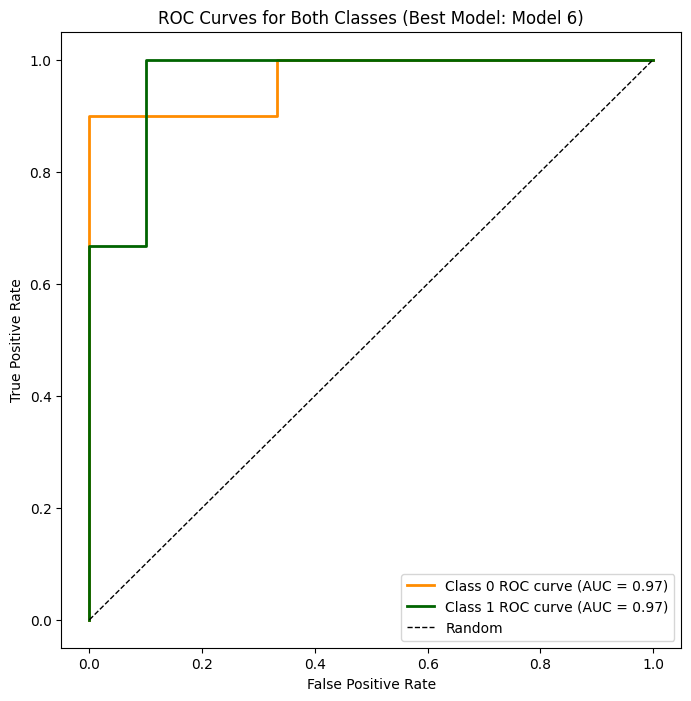

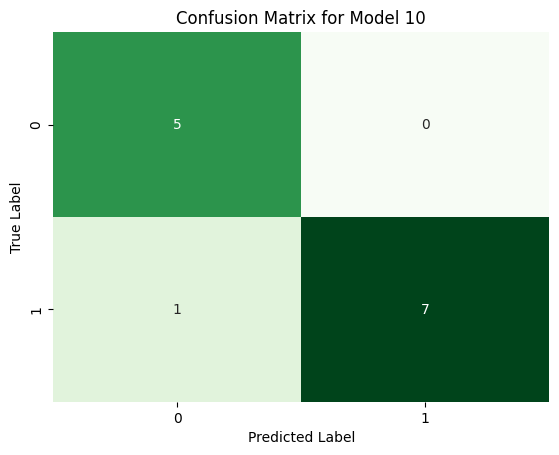

In [ ]:
# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

features = np.column_stack((atom_pairs_fingerprints, ff_values))

# Initialize lists to store evaluation metrics and confusion matrices
confusion_matrix_list = []
metrics_list = []

num_models = 200

# Initialize variables to track the best model
best_model_index = -1
best_f1_score = -1
best_accuracy = -1

# Run the model 200 times with different random states
for i in range(num_models):
    # Shuffle the data using a random number generator
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation] #changed line

    # Split the shuffled features and labels into training and testing datasets
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Initialize and train the SVC model
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append metrics to the list
    metrics_list.append({"Model": i + 1, "Accuracy": accuracy, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Update best model if the current model has higher F1 score and accuracy
    if f1 > best_f1_score and accuracy > best_accuracy:
        best_f1_score = f1
        best_accuracy = accuracy
        best_model_index = i

# Extract accuracy and F1 score from the metrics list
accuracies = [metrics["Accuracy"] for metrics in metrics_list]
f1_scores = [metrics["F1 Score"] for metrics in metrics_list]

# Calculate average accuracy and F1 score
average_accuracy = np.mean(accuracies)
average_f1_score = np.mean(f1_scores)

# Print or use the averages as needed
print(f'Average Accuracy: {average_accuracy}')
print(f'Average F1 Score: {average_f1_score}')

# Plot ROC curve only for the best model
if best_model_index != -1:
    # Use the best model's index to set the random state for reproducibility
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation]
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=best_model_index)

    # Initialize and train the best SVC model
    best_model = SVC(probability=True)
    best_model.fit(x_train, y_train)

    # Make predictions on the test set
    y_prob_best = best_model.predict_proba(x_test)

    # Calculate ROC curves for both classes
    fpr_0, tpr_0, _ = roc_curve(y_test, y_prob_best[:, 0], pos_label=0)
    roc_auc_0 = auc(fpr_0, tpr_0)

    fpr_1, tpr_1, _ = roc_curve(y_test, y_prob_best[:, 1], pos_label=1)
    roc_auc_1 = auc(fpr_1, tpr_1)

    # Plot ROC curve for the best model with AUC for both classes
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label=f'Class 0 ROC curve (AUC = {roc_auc_0:.2f})')
    plt.plot(fpr_1, tpr_1, color='darkgreen', lw=2, label=f'Class 1 ROC curve (AUC = {roc_auc_1:.2f})')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Both Classes (Best Model: Model {best_model_index + 1})')
    plt.legend(loc='lower right')
    plt.savefig('ROC-bestmode-seed45-Atompairs-t1.png')
    plt.show()
else:
    print("No best model found.")

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame to a CSV file
metrics_df.to_csv("individual_metrics-t1-seed45-Atompairs.csv", index=False)


# Plot the confusion matrix for a specific model (e.g., model 1)
chosen_model_index = 9  # Change this index as needed
sns.heatmap(confusion_matrix_list[chosen_model_index], annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title(f"Confusion Matrix for Model {chosen_model_index + 1}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('CM_model10-t1-Atompairs.png')
plt.show()

# Avalon

In [ ]:
from rdkit import Chem
from rdkit.Avalon import pyAvalonTools

# Read the uploaded Excel file
df = pd.read_excel("INPUT-CORRECT-ML-CLASS.xlsx")

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "Class"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
Avalon_fingerprints = [pyAvalonTools.GetAvalonFP(mol) for mol in mols]
len(mols)

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Print the length of the molecule and fingerprint lists
print(f"Number of molecules: {len(mols)}")
print(smiles_list)
print(f"Number of fingerprints: {len(fingerprints)}")
print(df["Class"])
#print(labels) #where are labels defined?
class_counts = df["Class"].value_counts()
print(class_counts)

Number of molecules: 63
['OC1=CC=CC(O)=C1', 'SC1=CC=CC=C1[S-]', 'OC1=CC=NC=C1O', 'OC1=C2C(C=CC=C2O)=CC=C1', '[NH3+]CCC1=CNC2=CC=C(C=C12)O', 'O=C1C([O-])=CC=CC=C1', 'OC1=CC=C(C(C)(C)C)C=C1O', 'O=C(C)NCCC1=CNC2=CC=C(C=C12)OC', '[NH3+]C[C@H](O)C1=CC=C(O)C(O)=C1', 'OC1=CC2=C(C=C1O)NC=C2', 'OC1=CC(Cl)=CC=C1O', '[O-]C([C@H](O)[C@@H](O)C([O-])=O)=O', 'OC1=C(O)C=CC(C([O-])=O)=C1', 'OCC(O)C(O)C(O)C(O)CO', 'OC1=C(O)C=CC(O)=C1', 'O=CC1=C(C=O)C=CC=C1', 'CCC1=CC=C(O)C(O)=C1', ' [NH3+]CCC1=CC=C(O)C(O)=C1', 'COC1=CC=CC=C1OC', 'O=C(C(C(C)(C)C)=CC(C(C)(C)C)=C1)C1=O', 'OC1=C(O)C=CC=C1OC', 'OC1=CC(N)=CC=C1O', 'OC1=C(C=O)C=CC=C1', 'OC1=C(CO)C=CC=C1', 'OC1=CC=CC=C1OC', 'OCC1=C(CO)C=CC=C1', 'OC1=CC([N+]([O-])=O)=CC=C1[O-]', 'CC(C1=CC=C(O)C(O)=C1)=O', 'OC1=C(O)C=CC(C(OC)=O)=C1', 'O=C(CO)C1=CC=CC=C1', 'OC(C([O-])=O)C1=CC=CC=C1', 'OC1=CC(C#N)=CC=C1O', 'OC1=C(O)C=CC(OC)=C1', 'OC1=CC=C(C=O)C=C1O', 'OC1=C(Cl)C=CC=C1O', 'OC1=CC=CN=C1O', 'OC1=CC=CC(O)=C1O', 'OC1=C(F)C=CC=C1O', 'OC1=CC(O)=CC(O)=C1', 'OC1=C(N)C=CC=C1

Average Accuracy: 0.8692307692307694
Average F1 Score: 0.8512535763170439


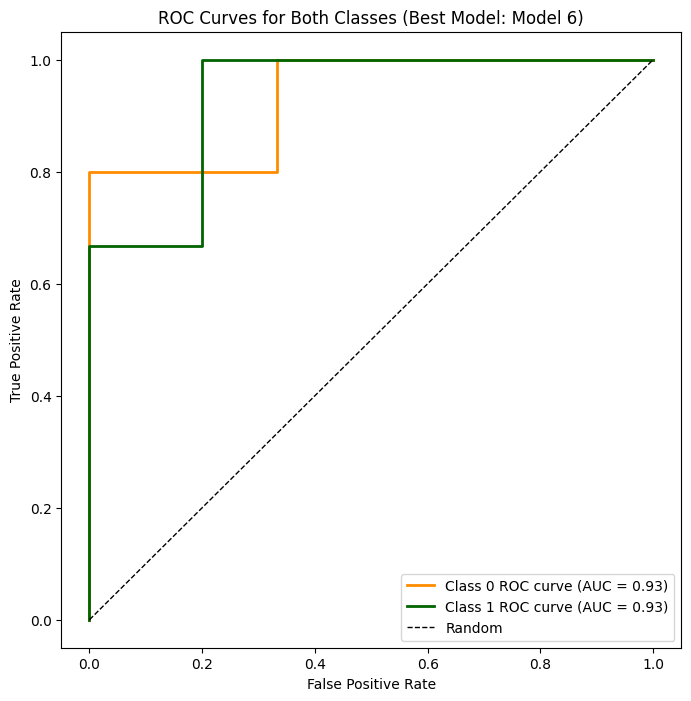

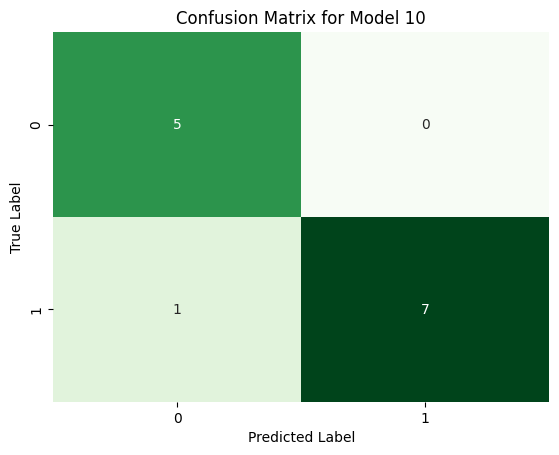

In [ ]:
# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

features = np.column_stack((Avalon_fingerprints, ff_values))

# Initialize lists to store evaluation metrics and confusion matrices
confusion_matrix_list = []
metrics_list = []

num_models = 200

# Initialize variables to track the best model
best_model_index = -1
best_f1_score = -1
best_accuracy = -1

# Run the model 200 times with different random states
for i in range(num_models):
    # Shuffle the data using a random number generator
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation] #changed line

    # Split the shuffled features and labels into training and testing datasets
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Initialize and train the SVC model
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append metrics to the list
    metrics_list.append({"Model": i + 1, "Accuracy": accuracy, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Update best model if the current model has higher F1 score and accuracy
    if f1 > best_f1_score and accuracy > best_accuracy:
        best_f1_score = f1
        best_accuracy = accuracy
        best_model_index = i

# Extract accuracy and F1 score from the metrics list
accuracies = [metrics["Accuracy"] for metrics in metrics_list]
f1_scores = [metrics["F1 Score"] for metrics in metrics_list]

# Calculate average accuracy and F1 score
average_accuracy = np.mean(accuracies)
average_f1_score = np.mean(f1_scores)

# Print or use the averages as needed
print(f'Average Accuracy: {average_accuracy}')
print(f'Average F1 Score: {average_f1_score}')

# Plot ROC curve only for the best model
if best_model_index != -1:
    # Use the best model's index to set the random state for reproducibility
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation]
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=best_model_index)

    # Initialize and train the best SVC model
    best_model = SVC(probability=True)
    best_model.fit(x_train, y_train)

    # Make predictions on the test set
    y_prob_best = best_model.predict_proba(x_test)

    # Calculate ROC curves for both classes
    fpr_0, tpr_0, _ = roc_curve(y_test, y_prob_best[:, 0], pos_label=0)
    roc_auc_0 = auc(fpr_0, tpr_0)

    fpr_1, tpr_1, _ = roc_curve(y_test, y_prob_best[:, 1], pos_label=1)
    roc_auc_1 = auc(fpr_1, tpr_1)

    # Plot ROC curve for the best model with AUC for both classes
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label=f'Class 0 ROC curve (AUC = {roc_auc_0:.2f})')
    plt.plot(fpr_1, tpr_1, color='darkgreen', lw=2, label=f'Class 1 ROC curve (AUC = {roc_auc_1:.2f})')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Both Classes (Best Model: Model {best_model_index + 1})')
    plt.legend(loc='lower right')
    plt.savefig('ROC-bestmode-Avalon-seed45-t1.png')
    plt.show()
else:
    print("No best model found.")

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame to a CSV file
metrics_df.to_csv("individual_metrics-t1-seed45-Avalon.csv", index=False)


# Plot the confusion matrix for a specific model (e.g., model 1)
chosen_model_index = 9  # Change this index as needed
sns.heatmap(confusion_matrix_list[chosen_model_index], annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title(f"Confusion Matrix for Model {chosen_model_index + 1}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('CM_model10-t1-seed45-Avalon.png')
plt.show()

# Torsion

In [ ]:
from rdkit.Chem import rdMolDescriptors

# Read the uploaded Excel file
df = pd.read_excel("INPUT-CORRECT-ML-CLASS.xlsx")

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "Class"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
torsion_fingerprints = [rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol) for mol in mols]
len(mols)

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Print the length of the molecule and fingerprint lists
print(f"Number of molecules: {len(mols)}")
print(smiles_list)
print(f"Number of fingerprints: {len(fingerprints)}")
print(df["Class"])
#print(labels) #where are labels defined?
class_counts = df["Class"].value_counts()
print(class_counts)

Number of molecules: 63
['OC1=CC=CC(O)=C1', 'SC1=CC=CC=C1[S-]', 'OC1=CC=NC=C1O', 'OC1=C2C(C=CC=C2O)=CC=C1', '[NH3+]CCC1=CNC2=CC=C(C=C12)O', 'O=C1C([O-])=CC=CC=C1', 'OC1=CC=C(C(C)(C)C)C=C1O', 'O=C(C)NCCC1=CNC2=CC=C(C=C12)OC', '[NH3+]C[C@H](O)C1=CC=C(O)C(O)=C1', 'OC1=CC2=C(C=C1O)NC=C2', 'OC1=CC(Cl)=CC=C1O', '[O-]C([C@H](O)[C@@H](O)C([O-])=O)=O', 'OC1=C(O)C=CC(C([O-])=O)=C1', 'OCC(O)C(O)C(O)C(O)CO', 'OC1=C(O)C=CC(O)=C1', 'O=CC1=C(C=O)C=CC=C1', 'CCC1=CC=C(O)C(O)=C1', ' [NH3+]CCC1=CC=C(O)C(O)=C1', 'COC1=CC=CC=C1OC', 'O=C(C(C(C)(C)C)=CC(C(C)(C)C)=C1)C1=O', 'OC1=C(O)C=CC=C1OC', 'OC1=CC(N)=CC=C1O', 'OC1=C(C=O)C=CC=C1', 'OC1=C(CO)C=CC=C1', 'OC1=CC=CC=C1OC', 'OCC1=C(CO)C=CC=C1', 'OC1=CC([N+]([O-])=O)=CC=C1[O-]', 'CC(C1=CC=C(O)C(O)=C1)=O', 'OC1=C(O)C=CC(C(OC)=O)=C1', 'O=C(CO)C1=CC=CC=C1', 'OC(C([O-])=O)C1=CC=CC=C1', 'OC1=CC(C#N)=CC=C1O', 'OC1=C(O)C=CC(OC)=C1', 'OC1=CC=C(C=O)C=C1O', 'OC1=C(Cl)C=CC=C1O', 'OC1=CC=CN=C1O', 'OC1=CC=CC(O)=C1O', 'OC1=C(F)C=CC=C1O', 'OC1=CC(O)=CC(O)=C1', 'OC1=C(N)C=CC=C1

Average Accuracy: 0.8984615384615385
Average F1 Score: 0.8824616773405474


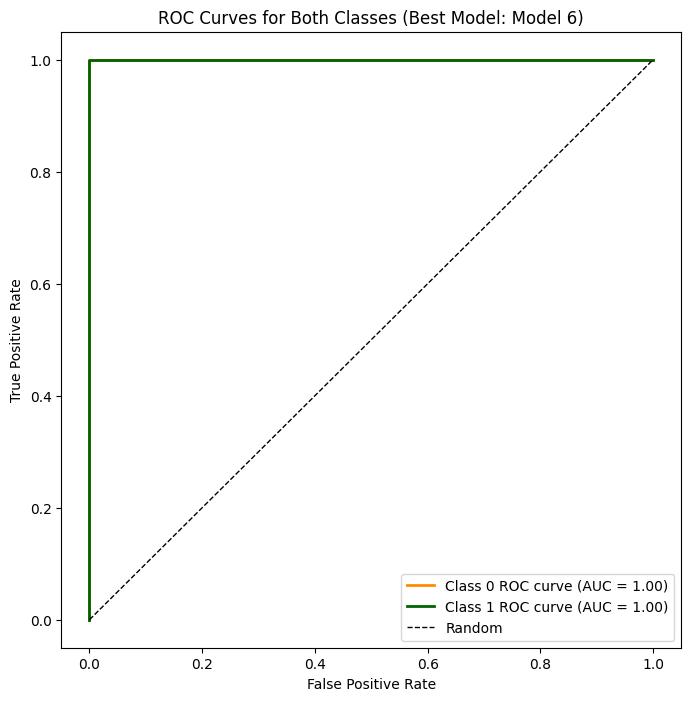

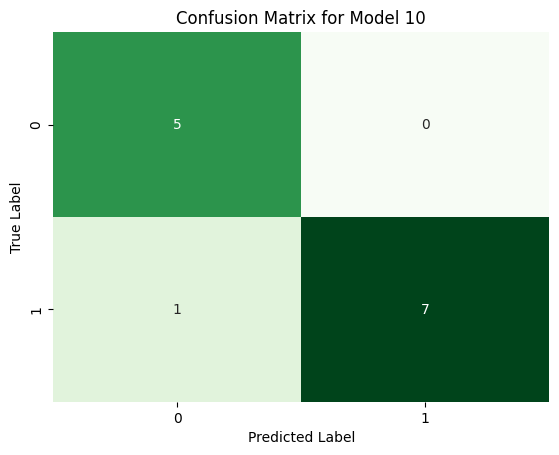

In [ ]:
# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

features = np.column_stack((torsion_fingerprints, ff_values))

# Initialize lists to store evaluation metrics and confusion matrices
confusion_matrix_list = []
metrics_list = []

num_models = 200

# Initialize variables to track the best model
best_model_index = -1
best_f1_score = -1
best_accuracy = -1

# Run the model 200 times with different random states
for i in range(num_models):
    # Shuffle the data using a random number generator
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation] #changed line

    # Split the shuffled features and labels into training and testing datasets
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Initialize and train the SVC model
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append metrics to the list
    metrics_list.append({"Model": i + 1, "Accuracy": accuracy, "F1 Score": f1, "Recall": recall})
    confusion_matrix_list.append(cm)

    # Update best model if the current model has higher F1 score and accuracy
    if f1 > best_f1_score and accuracy > best_accuracy:
        best_f1_score = f1
        best_accuracy = accuracy
        best_model_index = i

# Extract accuracy and F1 score from the metrics list
accuracies = [metrics["Accuracy"] for metrics in metrics_list]
f1_scores = [metrics["F1 Score"] for metrics in metrics_list]

# Calculate average accuracy and F1 score
average_accuracy = np.mean(accuracies)
average_f1_score = np.mean(f1_scores)

# Print or use the averages as needed
print(f'Average Accuracy: {average_accuracy}')
print(f'Average F1 Score: {average_f1_score}')

# Plot ROC curve only for the best model
if best_model_index != -1:
    # Use the best model's index to set the random state for reproducibility
    permutation = np.random.permutation(len(features))
    shuffled_features = features[permutation]
    shuffled_labels = df["Class"][permutation]
    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=best_model_index)

    # Initialize and train the best SVC model
    best_model = SVC(probability=True)
    best_model.fit(x_train, y_train)

    # Make predictions on the test set
    y_prob_best = best_model.predict_proba(x_test)

    # Calculate ROC curves for both classes
    fpr_0, tpr_0, _ = roc_curve(y_test, y_prob_best[:, 0], pos_label=0)
    roc_auc_0 = auc(fpr_0, tpr_0)

    fpr_1, tpr_1, _ = roc_curve(y_test, y_prob_best[:, 1], pos_label=1)
    roc_auc_1 = auc(fpr_1, tpr_1)

    # Plot ROC curve for the best model with AUC for both classes
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label=f'Class 0 ROC curve (AUC = {roc_auc_0:.2f})')
    plt.plot(fpr_1, tpr_1, color='darkgreen', lw=2, label=f'Class 1 ROC curve (AUC = {roc_auc_1:.2f})')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Both Classes (Best Model: Model {best_model_index + 1})')
    plt.legend(loc='lower right')
    plt.savefig('ROC-bestmode-Torsion-t1-seed45.png')
    plt.show()
else:
    print("No best model found.")

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame to a CSV file
metrics_df.to_csv("individual_metrics-t1-seed45-Torsion.csv", index=False)


# Plot the confusion matrix for a specific model (e.g., model 1)
chosen_model_index = 9  # Change this index as needed
sns.heatmap(confusion_matrix_list[chosen_model_index], annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title(f"Confusion Matrix for Model {chosen_model_index + 1}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('CM_model10-t1-seed45-Torsion.png')
plt.show()